In [277]:
using DataFrames
using RDatasets
using Statistics
using StatsPlots
using CSV
using StatsBase
using NamedArrays
using PrettyTables
using DecisionTree
using Shuffle


In [278]:
function mse(ŷ::Vector{T}, y::Vector{T})::T where T<:AbstractFloat
	mean((ŷ .- y).^2)
end

mse (generic function with 1 method)

In [279]:
df = CSV.read(joinpath(dirname(pwd()), "Concrete_Data.csv"), DataFrame)

Row,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Compressive strength (MPa)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
2,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
4,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
5,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.3
6,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.7
8,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
9,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85


In [280]:
dfm = Matrix(df)
dfm = dfm[shuffle(1:end), :]

x = dfm[:, 1:8]
y = dfm[:, 9]

data_split = [0.6, 0.3, 0.1]
split_cs2 = Int.(round.(cumsum(data_split)*length(y)))
split_cs1 = vcat(1, split_cs2[1:(end-1)].+1)

xtrain = x[split_cs1[1]:split_cs2[1], :]
ytrain = y[split_cs1[1]:split_cs2[1]]

xtest = x[split_cs1[2]:split_cs2[2], :]
ytest = y[split_cs1[2]:split_cs2[2]]

xval = x[split_cs1[3]:split_cs2[3], :]
yval = y[split_cs1[3]:split_cs2[3]];

In [281]:
# set of regression parameters and respective default values
# pruning_purity: purity threshold used for post-pruning (default: 1.0, no pruning)
# max_depth: maximum depth of the decision tree (default: -1, no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 5)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)
# n_subfeatures: number of features to select at random (default: 0, keep all)
# keyword rng: the random number generator or seed to use (default Random.GLOBAL_RNG)
n_subfeatures = 0; max_depth = -1; min_samples_leaf = 5
min_samples_split = 2; min_purity_increase = 0.0; pruning_purity = 1.0 ; seed=3

model = build_tree(ytrain, xtrain,
                   n_subfeatures,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split,
                   min_purity_increase;
                   rng = seed)

Decision Tree
Leaves: 96
Depth:  11

In [282]:
# To avoid overfitting
model = prune_tree(model, 0.9)

Decision Tree
Leaves: 96
Depth:  11

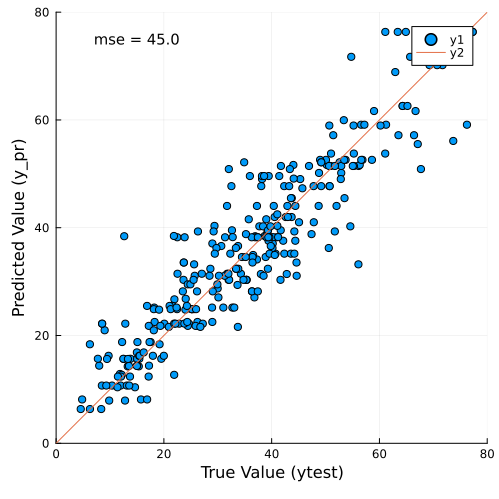

In [283]:
# apply learned model
y_pr = apply_tree(model, xtest)

compare_plt = plot(ytest, y_pr, 
st=:scatter,
xlims=(0,80),
ylims=(0,80),
xlab = "True Value (ytest)",
ylab = "Predicted Value (y_pr)",
size = (500,500),
aspect_ratio=:equal)

xx = 0:80
yy = 0:80

plot!(compare_plt, xx, yy, st=:line)

mse_SVR = mse(y_pr, ytest)
annotate!(15,75, text("mse = $(round(mse_SVR, sigdigits=2))", 10))

display(compare_plt)

In [284]:
r2 = nfoldCV_tree(ytrain, xtrain, 3)


Fold 1
Mean Squared Error:     76.71204209116733
Correlation Coeff:      0.8621133287202037
Coeff of Determination: 0.7390690057244762

Fold 2
Mean Squared Error:     64.35982971636325
Correlation Coeff:      0.8880280676972621
Coeff of Determination: 0.786505810981917

Fold 3
Mean Squared Error:     66.34418277426572
Correlation Coeff:      0.8732435916197614
Coeff of Determination: 0.7474324026824994

Mean Coeff of Determination: 0.7576690731296308


3-element Vector{Float64}:
 0.7390690057244762
 0.786505810981917
 0.7474324026824994

In [285]:
# set of regression build_forest() parameters and respective default values
# n_subfeatures: number of features to consider at random per split (default: -1, sqrt(# features))
# n_trees: number of trees to train (default: 10)
# partial_sampling: fraction of samples to train each tree on (default: 0.7)
# max_depth: maximum depth of the decision trees (default: no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 5)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)
# keyword rng: the random number generator or seed to use (default Random.GLOBAL_RNG)
#              multi-threaded forests must be seeded with an `Int`
n_subfeatures=-1; n_trees=10; partial_sampling=0.7; max_depth=-1
min_samples_leaf=5; min_samples_split=2; min_purity_increase=0.0; seed=rand(1:1000)
model_forest = build_forest(ytrain, xtrain,
                     n_subfeatures,
                     n_trees,
                     partial_sampling,
                     max_depth,
                     min_samples_leaf,
                     min_samples_split,
                     min_purity_increase;
                     rng = seed)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 68.1
Avg Depth:  11.4

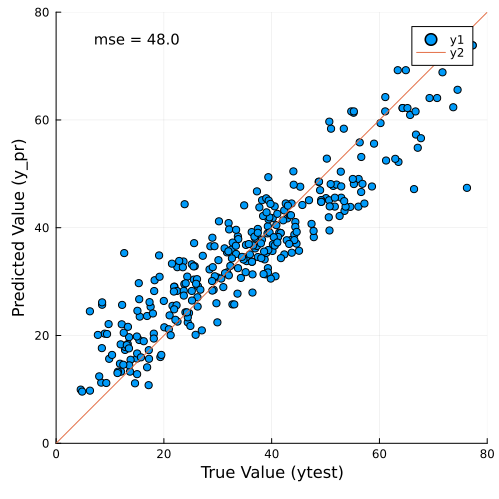

In [286]:
# apply learned model
y_pr = apply_forest(model_forest, xtest)

compare_plt = plot(ytest, y_pr, 
st=:scatter,
xlims=(0,80),
ylims=(0,80),
xlab = "True Value (ytest)",
ylab = "Predicted Value (y_pr)",
size = (500,500),
aspect_ratio=:equal)

xx = 0:80
yy = 0:80

plot!(compare_plt, xx, yy, st=:line)

mse_SVR = mse(y_pr, ytest)
annotate!(15,75, text("mse = $(round(mse_SVR, sigdigits=2))", 10))

display(compare_plt)

In [287]:
r2 = nfoldCV_tree(labels, features, 3)


Fold 1
Mean Squared Error:     50.48718069769522
Correlation Coeff:      0.9076120193621697
Coeff of Determination: 0.8217577201033399

Fold 2
Mean Squared Error:     63.607372848589634
Correlation Coeff:      0.8768122726132358
Coeff of Determination: 0.7658288423607998

Fold 3
Mean Squared Error:     59.27286002652123
Correlation Coeff:      0.8915828064060386
Coeff of Determination: 0.7878104640898367

Mean Coeff of Determination: 0.7917990088513255


3-element Vector{Float64}:
 0.8217577201033399
 0.7658288423607998
 0.7878104640898367